In [186]:
# Computational Physics Project 4 - Molecular Orbital Theory
# Ben Zager, Zach Faber-Manning, Michael Rosen

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.linalg import eigh,solve,norm

np.set_printoptions(precision=3)


In [187]:
# import Huckel matrices (adjacency matrix of carbon chain)

buta = np.loadtxt("butadiene.txt")
benz = np.loadtxt("benzene.txt")
tolu = np.loadtxt("toluene.txt")
naph = np.loadtxt("naphthalene.txt")
ethy = np.loadtxt("ethylene.txt")
buck = np.loadtxt("buckyball.txt")

In [190]:
# Select molecule

adj = buta

N = adj.shape[0] # number of carbons
Ne = N # number of electrons
db = 2 # number of double bonds (2 for butadiene, 3 for benzene/toluene, 5 for naphthalene, 30 for buckyball)

In [191]:
# Compute eigenvalues and eigenvectors

# gram schmidt method to orthonormalize eigenvectors
# M is a matrix with each column an eigenvector, V is new matrix
# adapted from andreask.cs.illinois.edu/cs357-s15/public/demos/05-orthgonality/Gram-Schmidt%20and%20Modified%20Gram-Schmidt.py
def gramSchmidt(M):
    n = M.shape[0]
    V = np.zeros([n,n])
    V[:,0] = M[:,0] / norm(M[:,0])

    for i in range(n):
        q = M[:,i]
        for j in range(i):
            q = q - np.dot(q,V[:,j])*V[:,j]
    
        V[:,i] = q/norm(q)
        
    return V
    

# Finds eigenvalues and eigenvectors
# args: adjacency matrix
# rets: tuple, (eigenvalues,eigenvectors) 
def getEigs(adj):
    eigs = eigh(adj)
    evals = np.flip(np.around(eigs[0],4),0) # eigenvalues
    evecs = np.flip(np.around(eigs[1],4),1) # eigenvectors
    
    evecs = gramSchmidt(evecs) # orthogonalize eigenvectors
    
    return (evals,evecs)

evals,evecs = getEigs(adj)

print("Eigenvalues\n")
for i in range(N):
    print(str(i+1)+" : a + "+str(np.around(evals[i],3))+"b  " + str(np.around(evecs[:,i],3)))

#print(np.dot(evecs[0],evecs[4]))

Eigenvalues

1 : a + 1.618b  [ 0.372  0.602  0.602  0.372]
2 : a + 0.618b  [-0.602 -0.372  0.372  0.602]
3 : a + -0.618b  [ 0.602 -0.372 -0.372  0.602]
4 : a + -1.618b  [ 0.372 -0.602  0.602 -0.372]


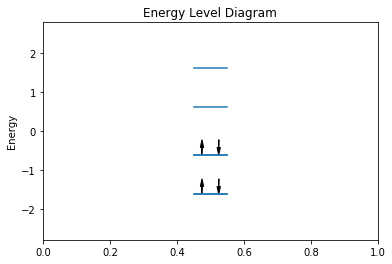

Electron energies: [-1.618 -1.618 -0.618 -0.618]
Occupation numbers: [ 2.  2.  0.  0.]
Total ground state energy: -4.472b


In [194]:
# Very ugly function, try to improve

# Plots energy level diagram and determines electron energies
# args: ordered list of eigenvalues, number of electrons
# rets: list of energies for the Ne electrons
def energyLevel(evals,Ne,show=True):
    
    # parameters for drawing diagram
    mid = 0.5 # midpoint
    width = 0.1 # width of each line
    space = 0.05 # spacing between lines
    arrlen = 0.2 # arrow length
    hw = 0.01 # width of head of arrow
    hl = 0.2 # length of head of arrow

    # get unique list of energies
    # returns tuple of two arrays, ([energies],[multiplicity])
    uniq = np.unique(np.around(evals,4),return_counts=True)

    energies = np.zeros(Ne) # stores energies of each electron
    occu = np.zeros(N) # occupation number
    filled = 0 # keep track of how many electrons are left
    orb = 1 # keep track of current orbital
    
    for i in range(uniq[0].size): # go through each unique energy level
        E = uniq[0][i]
        m = uniq[1][i] # multiplicity
        start = mid - 0.5*(m-1)*(width+space) # where first line is drawn (left edge)
        
        turn = 1 # 1st or 2nd sweep through level
        j = 0 # keep track of degenerate energy levels
        
        while j < m:
            xL = start + j*(width+space) - 0.5*width # set bounds for drawing line
            xR = xL + width
            plt.axhline(E,xmin=xL,xmax=xR) # draw horizontal line
            if filled < Ne:
                energies[filled] = E
                if turn == 1:
                    elec = 0.95*np.mean([xL,xR])
                    plt.arrow(elec,E,0,arrlen,head_width=hw,head_length=hl,fc='k',ec='k')
                    filled += 1
                    occu[orb-1] = 1
                    if j == m-1:
                        turn = 2
                        j = 0
                        orb -= (m-1)
                        continue     
                elif turn == 2:
                    elec = 1.05*np.mean([xL,xR])
                    plt.arrow(elec,E+arrlen+hl,0,-arrlen,head_width=hw,head_length=hl,fc='k',ec='k')
                    filled += 1
                    occu[orb-1] = 2
                orb += 1
            j += 1
    
    plt.ylabel("Energy")
    plt.xlim([0,1])
    plt.ylim([1.1*np.min(evals)-1,1.1*np.max(evals)+1])
    plt.title("Energy Level Diagram")
    if show:
        plt.show()
        
    return energies,occu

energies,occu = energyLevel(evals,Ne)
ETot = np.sum(energies)
print("Electron energies:",energies)
print("Occupation numbers:",occu)
print("Total ground state energy:",str(ETot)+"b")


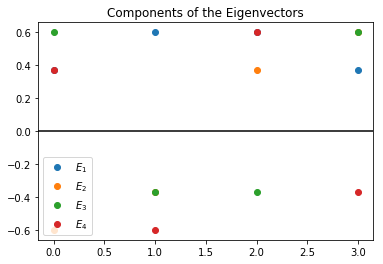

In [195]:
# Plot eigenvectors

for i in range(N):
    plt.plot(evecs[:,i],'o',label=r"$E_"+str(i+1)+"$")

plt.axhline(0,color='k')
plt.title("Components of the Eigenvectors")
plt.legend()
plt.show()

In [198]:
# Delocalization energy
# energy difference from ground state and isolated double bonds (compare to ethylene)
# 

# determine delocalization energy, given total ground state energy and number of double bonds
def calcDeloc(E,numDB):
    Ne_ethy = 2
    evals_ethy = getEigs(ethy)[0]
    E_ethy = energyLevel(evals_ethy,Ne_ethy,show=False)[0]
    ETot_ethy = np.sum(E_ethy)
    deloc = numDB*ETot_ethy - ETot

    return deloc

deloc = calcDeloc(ETot,db)

print(str(deloc)+"b")

0.472b


In [199]:
# Charge density estimation 
# for single electron in orbital I, |c_Ir|^2 is probability of electron being on atom r

def chargeDensity(evecs,energies,occu):
    q = np.zeros(N)
        
    for r in range(N):
        c = evecs[:,r] # get the rth component of eigenvector
        cSq = np.square(c)
        q[r] = np.dot(cSq,occu)
    
    return q

q = chargeDensity(evecs,energies,occu)

print(q)

[ 1.  1.  1.  1.]


In [206]:
# Bond order calculation

def bondOrder(adj,evecs,energies,occu):
    adjUp = np.triu(adj) # remove redundant elements
    r,s = np.nonzero(adjUp) # get indices of nonzero elements
    p = np.zeros(r.size)
    
    for i in range(r.size):
        cr = evecs[:,r[i]]
        cs = evecs[:,s[i]]
                        
        cPr = np.multiply(cr,cs)
        
        p[i] = np.dot(cPr,occu)
    
    return p
    
p = bondOrder(adj,evecs,energies,occu)

print(p)

[-0.894 -0.447  0.894]
